## 1. Setup

In [1]:
import sys
sys.path.append('../..')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import shutil
import warnings

from keras import Model
from neural_networks.fcrn import FCRN_A
from utils.data.data_generator import DataGenerator
from utils.data.data_ops import move_val_split_to_train
from utils.data.data_ops import create_val_split_from_train
from utils.input_output.io import save_np_arrays
from pprint import pprint

Using TensorFlow backend.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

## 2. Experiment parameters

In [4]:
DATASET_NAME = 'shanghai_tech/part_b'
DATASET_PATH = f'../../datasets/{DATASET_NAME}'
IMG_DIM = None
D_MAP_MULT_FACT = None
LOSS_FUNCTIONS = ['mse']#, 'mae', 'logcosh']
EXP_DIR_NAMES = []

if DATASET_NAME.lower() == 'vgg_cells':
    # misc
    IMG_DIM = (256, 256, 3)
    D_MAP_MULT_FACT = 100.
    
    # plots
    figsize=(25, 5)
    fraction = 0.045
    pad = 0.038
    
    # checkpoints
    for loss_name in LOSS_FUNCTIONS:
        for input_type in ['patch_4_128x128']:#'full_img',
            for train_size in [64]:
                for rseed_idx in [5]:#range(1, 6):
                    exp_dir_name =  f'./vgg_cells/'\
                                    f'n_{train_size}_sigma_5_'\
                                    f'randseed_{train_size}{rseed_idx}_'\
                                    f'loss_{loss_name}_'\
                                    f'{input_type}'
                    EXP_DIR_NAMES.append(exp_dir_name)
    
elif DATASET_NAME.lower() == 'carpk':
    # misc
    IMG_DIM = (720, 1280, 3)
    D_MAP_MULT_FACT = 2000.
    
    # plots
    figsize=(25, 7)
    fraction = 0.027
    pad = 0.015
    
    # checkpoints
    EXP_DIR_NAMES = ['./carpk/sigma_10_loss_logcosh_full_img_epochs_10_lr_1e-4']
                     #'./carpk/sigma_10_loss_mse_full_img',
                     #'./carpk/sigma_10_loss_mse_patch_32_128x128_epochs_3']
                    #['./carpk/sigma_10_loss_logcosh_patch_32_128x128_15_epochs']
                    #['./carpk/sigma_10_loss_logcosh_patch_32_128x128_5_epochs']
    
elif DATASET_NAME.lower() == 'shanghai_tech/part_b':
    # misc
    IMG_DIM = (768, 1024, 3)
    D_MAP_MULT_FACT = 2000.
    
    # plots
    figsize=(25, 7)
    fraction = 0.0355
    pad = 0.015
    
    # checkpoints
    EXP_DIR_NAMES = ['./shanghai_tech/part_b/sigma_10_loss_logcosh_patch_16_256x256_epochs_50_lr_1e-4']
    '''
     ['./shanghai_tech/part_b/sigma_10_loss_logcosh_full_img_epochs_30',
     './shanghai_tech/part_b/sigma_10_loss_logcosh_patch_32_128x128_epochs_100',
     './shanghai_tech/part_b/sigma_10_loss_mse_full_img',
     './shanghai_tech/part_b/sigma_10_loss_mse_patch_32_128x128_epochs_100']
    '''

In [5]:
params = {
    'dim': IMG_DIM,
    'batch_size': 1,
    'patches_per_image': 1,
    'density_map_multiplication_factor': D_MAP_MULT_FACT,
    'shuffle': False
}

In [6]:
print(len(EXP_DIR_NAMES))
pprint(EXP_DIR_NAMES)

1
['./shanghai_tech/part_b/sigma_10_loss_logcosh_patch_16_256x256_epochs_50_lr_1e-4']


## 3. Predict and save results

In [7]:
gt_counts = []
pred_counts = []

for exp_dir_name in [EXP_DIR_NAMES[0]]:
    if 'vgg_cells' in DATASET_PATH:
        # for vgg_cells dataset we divide the train set in different train/val split each time
        train_path = f'{DATASET_PATH}/train'
        val_path = f'{DATASET_PATH}/val'
        
        train_size = int(re.search(r'/n_\d{2}_', exp_dir_name).group().split('_')[1])
        val_size = 100 - train_size
        rand_seed = int(re.search(r'randseed_\d{3}_', exp_dir_name).group().split('_')[1])
        
        move_val_split_to_train(val_path, train_path)
        create_val_split_from_train(train_path, val_path, val_size, rand_seed)
        
    # data splits
    train_generator = DataGenerator(DATASET_PATH, 'train', **params)
    val_generator = DataGenerator(DATASET_PATH, 'val', **params)
    test_generator = DataGenerator(DATASET_PATH, 'test', **params)
    
    # clean old dir for qualitative results
    results_path = f'{exp_dir_name}/results/qualitative'
    shutil.rmtree(results_path, ignore_errors=True)
    os.makedirs(results_path)

    # predict and save
    #####checkpoint_filename = f'{exp_dir_name}/checkpoints/best_model.hdf5'
    checkpoint_filename = f'{exp_dir_name}/checkpoints/model.48-0.083.hdf5'
    model = FCRN_A(pretrained_weights=checkpoint_filename)
    
    for data_generator, split_name in zip([test_generator],
                                          ['test']):
        # prepare dirs for qualitative results
        results_path_npy = f'{results_path}/{split_name}/npy'
        results_path_png = f'{results_path}/{split_name}/png'
        results_path_png_diff = f'{results_path}/{split_name}/png_diff'
        results_path_png_gt_asc = f'{results_path}/{split_name}/png_gt_asc'
        os.makedirs(results_path_npy)
        os.makedirs(results_path_png)
        os.makedirs(results_path_png_diff)
        os.makedirs(results_path_png_gt_asc)
        
        for idx in range(data_generator.__len__()):
            # input image & gt density map, batch_size=1
            input_img, gt_density_map = data_generator.__getitem__(idx)
            gt_density_map /= D_MAP_MULT_FACT
            
            # predicted density map
            pred_density_map = (model.predict(input_img) / D_MAP_MULT_FACT)[0]
            
            # gt & pred counts
            gt_count = int(np.round(gt_density_map.sum()))
            pred_count = pred_density_map.sum()
            pred_gt_diff = pred_count - gt_count
            
            gt_counts.append(gt_count)
            pred_counts.append(pred_count)
            
            error_type = 'match'
            if pred_count < gt_count:
                error_type = 'underestimate'
            elif pred_count > gt_count:
                error_type = 'overestimate'
            
            img_name_png = data_generator.img_names[data_generator.indexes[idx]]
            img_name = img_name_png.split('.')[0]
            img_name_npy = f'{img_name}_gt_{gt_count}_pred_{pred_count:.2f}'\
                           f'_diff_gt_pred_{pred_gt_diff:.2f}'
            img_name_diff = f'{error_type}_{np.abs(pred_gt_diff):7.2f}'\
                            f'_gt_{gt_count}_pred_{pred_count:.2f}'\
                            f'_{img_name}'.replace(' ', '0')
            img_name_gt_asc = f'gt_{gt_count:3}_pred_{pred_count:6.2f}_diff_gt_pred_{pred_gt_diff:.2f}'\
                              f'_{img_name}'.replace(' ', '0')
            
            # .npy arrays
            #####save_np_arrays([pred_density_map], [img_name_npy], results_path_npy)
            
            # plots
            vmin = min(gt_density_map.min(), pred_density_map.min())
            vmax = max(gt_density_map.max(), pred_density_map.max())
            
            fig = plt.figure(figsize=figsize)

            plt.subplot(1, 4, 1)
            plt.title('Input image')
            plt.imshow(input_img[0])
            plt.axis('off')

            plt.subplot(1, 4, 2)
            plt.title(f'GT density map ({gt_count})')
            plt.imshow(gt_density_map.squeeze(), cmap='jet', vmin=vmin, vmax=vmax)
            plt.colorbar(fraction=fraction, pad=pad)
            plt.axis('off')

            plt.subplot(1, 4, 3)
            plt.title(f'Predicted density map ({pred_count:.2f})')
            plt.imshow(pred_density_map.squeeze(), cmap='jet', vmin=vmin, vmax=vmax)
            plt.colorbar(fraction=fraction, pad=pad)
            plt.axis('off')

            plt.subplot(1, 4, 4)
            plt.title(f'Prediction - GT ({(pred_density_map - gt_density_map).sum():.2f})')
            plt.imshow((pred_density_map - gt_density_map).squeeze(), cmap='gray')
            plt.colorbar(fraction=fraction, pad=pad)
            plt.axis('off')

            plt.savefig(f'{results_path_png}/{img_name_npy}.png')
            plt.savefig(f'{results_path_png_diff}/{img_name_diff}.png')
            plt.savefig(f'{results_path_png_gt_asc}/{img_name_gt_asc}.png')
            plt.clf()
            plt.close()

## 4. Plot GT vs Prediction

In [8]:
print(gt_counts)
print(pred_counts)

[23, 181, 157, 37, 70, 57, 44, 227, 165, 476, 139, 303, 164, 110, 20, 131, 48, 183, 101, 203, 40, 143, 146, 513, 70, 175, 51, 54, 67, 72, 56, 165, 32, 149, 48, 80, 115, 162, 137, 120, 72, 122, 198, 132, 147, 29, 70, 35, 24, 251, 59, 67, 61, 248, 252, 147, 57, 121, 47, 505, 297, 464, 167, 43, 46, 91, 263, 92, 117, 48, 54, 73, 122, 60, 170, 167, 57, 127, 71, 298, 14, 11, 104, 143, 45, 229, 20, 41, 79, 235, 101, 60, 253, 187, 184, 106, 104, 159, 56, 40, 277, 90, 301, 58, 172, 213, 61, 107, 93, 9, 88, 52, 15, 48, 131, 180, 187, 148, 57, 86, 106, 72, 149, 89, 33, 51, 138, 284, 138, 52, 161, 109, 73, 448, 300, 70, 74, 154, 144, 142, 265, 94, 96, 159, 64, 240, 93, 79, 133, 29, 212, 180, 196, 323, 51, 166, 79, 94, 89, 177, 143, 105, 85, 376, 104, 62, 107, 216, 24, 274, 31, 131, 91, 49, 194, 131, 55, 87, 38, 53, 184, 137, 95, 36, 28, 59, 62, 79, 304, 207, 142, 54, 164, 61, 200, 88, 38, 67, 57, 196, 61, 87, 146, 24, 226, 38, 54, 66, 89, 19, 45, 92, 119, 177, 93, 327, 46, 153, 28, 66, 206, 98, 61

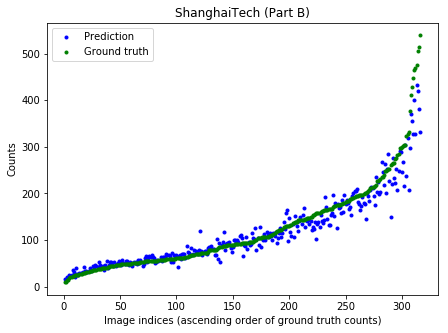

In [10]:
x = 1 + np.arange(len(gt_counts))
indices = np.argsort(gt_counts)
plt.figure(figsize=(7, 5))
plt.title('ShanghaiTech (Part B)')
plt.plot(x, np.asarray(pred_counts)[indices], 'b.', label='Prediction')
plt.plot(x, np.asarray(gt_counts)[indices], 'g.', label='Ground truth')
plt.ylabel('Counts')
plt.xlabel('Image indices (ascending order of ground truth counts)')
plt.legend()
plt.show()